# Neural Net Language models

> Basic neuralnet-based language modeling 

In [ ]:
#| default_exp models.lm

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export

# torch
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torchmetrics import Accuracy


import lightning as L
from lightning import Trainer

# plot
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

from omegaconf import OmegaConf
from hydra.utils import instantiate

# python
from typing import Dict, List, Tuple, Optional, Set
from dataclasses import dataclass, asdict

from nimrod.text.datasets import CharDataset, Vocab

# N_EPOCHS for training debuggging
ITER_MAX = 5


In [ ]:
# reading with pandas
df = pd.read_csv('../data/text/names.txt', header=None, names=['name'])
data = list(df.name)
print("names: ", data[:3])

# reading directly in plain python
lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add special tokens
data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]
print("shakespeare: ", data[:3])

v = Vocab('../data/text/tiny_shakespeare.txt')
print(v.stoi('e'))
print(v.itos(8))
print("pad: ", v.stoi('<pad>'))
print(v.stoi(['e','m']))
print(v.itos([8,17]))
print(len(v))
print(''.join(v.vocabulary))

names:  ['emma', 'olivia', 'ava']
shakespeare:  [['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>'], ['<bos>', 'A', 'l', 'l', ':', '<eos>']]
6
t
pad:  0
[6, 20]
['t', 'l']
70
 !$&',-.3:;<<bos><eos><pad><unk>>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [ ]:
# print first 4 lines of the file
for i in range(4):
    print(data[i])

['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>']
['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']
['<bos>', 'A', 'l', 'l', ':', '<eos>']
['<bos>', 'S', 'p', 'e', 'a', 'k', ',', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']


In [ ]:
names = list(df.name)
print(len(names), names)

32033 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily', 'elizabeth', 'mila', 'ella', 'avery', 'sofia', 'camila', 'aria', 'scarlett', 'victoria', 'madison', 'luna', 'grace', 'chloe', 'penelope', 'layla', 'riley', 'zoey', 'nora', 'lily', 'eleanor', 'hannah', 'lillian', 'addison', 'aubrey', 'ellie', 'stella', 'natalie', 'zoe', 'leah', 'hazel', 'violet', 'aurora', 'savannah', 'audrey', 'brooklyn', 'bella', 'claire', 'skylar', 'lucy', 'paisley', 'everly', 'anna', 'caroline', 'nova', 'genesis', 'emilia', 'kennedy', 'samantha', 'maya', 'willow', 'kinsley', 'naomi', 'aaliyah', 'elena', 'sarah', 'ariana', 'allison', 'gabriella', 'alice', 'madelyn', 'cora', 'ruby', 'eva', 'serenity', 'autumn', 'adeline', 'hailey', 'gianna', 'valentina', 'isla', 'eliana', 'quinn', 'nevaeh', 'ivy', 'sadie', 'piper', 'lydia', 'alexa', 'josephine', 'emery', 'julia', 'delilah', 'arianna', 'vivian', 'kaylee', 'sophie', 'brielle', 'madeline', 'peyton',

## Data formatting
given last n tokens we predict token n+1

In [ ]:
s = list("alexandra")
print(s)
bigram = [(x,y) for x, y in zip(s, s[1:])]
print(bigram)
trigram = [ (x,y,z) for x, y, z in zip(s, s[1:], s[2:])]
print(trigram)

['a', 'l', 'e', 'x', 'a', 'n', 'd', 'r', 'a']
[('a', 'l'), ('l', 'e'), ('e', 'x'), ('x', 'a'), ('a', 'n'), ('n', 'd'), ('d', 'r'), ('r', 'a')]
[('a', 'l', 'e'), ('l', 'e', 'x'), ('e', 'x', 'a'), ('x', 'a', 'n'), ('a', 'n', 'd'), ('n', 'd', 'r'), ('d', 'r', 'a')]


### Tiny shakespeare LM char dataset

In [ ]:

lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add special tokens
data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]
print("shakespeare: ", data[:3])

v = Vocab('../data/text/tiny_shakespeare.txt')

shakespeare:  [['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>'], ['<bos>', 'A', 'l', 'l', ':', '<eos>']]


In [ ]:

def make_dataset(
        words:List[str], # data is a list of sentences which are a list of words
        v:Vocab,# vocabulary class for mapping words to indices
        verbose:bool=False, # print debug info
        context_length=3 # number of words/tokens to use as context
        ):
    X = []
    y = []
    for word in words:
        s = list(word)
        if verbose:
            print('row: ', s)
        # init prefix with padding while len < context_length
        for i in range(context_length-1):
            sequence = v.stoi(s[:i+1])
            pad_len = context_length - len(sequence)
            pad = [v.stoi("<pad>")] * pad_len
            X.append(pad + sequence)
            y.append(v.stoi(s[i+1]))

            if verbose:
                print(["<pad>"]+ s[:i+1], s[i+1])

        # for length seq = context_length
        i = 0
        while i < (len(s) - context_length):
            X.append(v.stoi(s[i:context_length+i]))
            y.append(v.stoi(s[i+context_length]))
            if verbose:
                print(s[i:context_length+i], s[i+context_length])
            i += 1
    return torch.tensor(X),torch.tensor(y)


In [ ]:
print(data[:2])

[['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']]


for each row in the dataset we expand all the combinations of ngrams

In [ ]:
CONTEXT_LEN = 3
# from 2 rows/sentences of data we get 61 tri-grams & n+1 character prediction
X, y = make_dataset(data[:2], v, verbose=True, context_length=CONTEXT_LEN)
print("X: ", X.shape, "y:", y.shape)

row:  ['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>']
['<pad>', '<bos>'] F
['<pad>', '<bos>', 'F'] i
['<bos>', 'F', 'i'] r
['F', 'i', 'r'] s
['i', 'r', 's'] t
['r', 's', 't']  
['s', 't', ' '] C
['t', ' ', 'C'] i
[' ', 'C', 'i'] t
['C', 'i', 't'] i
['i', 't', 'i'] z
['t', 'i', 'z'] e
['i', 'z', 'e'] n
['z', 'e', 'n'] :
['e', 'n', ':'] <eos>
row:  ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']
['<pad>', '<bos>'] B
['<pad>', '<bos>', 'B'] e
['<bos>', 'B', 'e'] f
['B', 'e', 'f'] o
['e', 'f', 'o'] r
['f', 'o', 'r'] e
['o', 'r', 'e']  
['r', 'e', ' '] w
['e', ' ', 'w'] e
[' ', 'w', 'e']  
['w', 'e', ' '] p
['e', ' ', 'p'] r
[' ', 'p', 'r'] o
['p', 'r', 'o'] c
['r', 'o', 'c'] e
['o', 'c', 'e'] e
['c', 'e', 'e'] d
['e', 'e', 'd']  
['e', 'd', ' '] a
['d', ' '

In [ ]:
# take first 80 sentences & look at context_length sequences
X, y = make_dataset(data[:80], v, verbose=False, context_length=CONTEXT_LEN)
print(len(X), len(y))

2703 2703


## MLP LM Model
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [ ]:
# F.one_hot(torch.tensor(5), num_classes=n_vocab).float()@C # == C[5]

In [ ]:
#| export

@dataclass
class NNLMConfig:
    n_vocab:int = 30
    n_emb:int = 10
    n_context:int = 3
    n_h:int = 100

class NNLM(nn.Module):
    def __init__(self,
                n_vocab:int, # vocabulary size 
                n_emb:int, # embedding dimension
                n_context:int, # context size bigram/trigram, etc.
                n_h:int # hidden layer size
                ):
        super().__init__()
        # to each token id from n_vocab in sequence T coresponds a embedding of size n_emb (C)
        self.embedder = nn.Embedding(n_vocab, n_emb) # (B,T)->(B,T,C)
        self.n_emb = n_emb
        self.n_context = n_context
        # we concatenate input of [n_context length, n_emb] into linear layer (T*C):
        self.l1 = nn.Linear(n_context * n_emb, n_h) 
        self.l2 = nn.Linear(n_h, n_vocab)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        # input: (B,T)
        embedding = self.embedder(x) # ->(B,T,C)
        # we concatenate input of n_context length * n_emb (T*C) into linear layer:
        h = self.l1(embedding.view(-1,self.n_context * self.n_emb))
        h = torch.tanh(h)
        logits = self.l2(h)
        return(logits)
    
    def sample(self, n_iterations:int=10, eos:int=3, pad:int=0, bos:int=2)->str:
        res = []
        for _ in range(n_iterations):
            out = [] # current sequence prediction
            context = [pad] * (self.n_context-1) + [bos]
            while True:
                logits = self(torch.tensor([context]))
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples=1).item()
                context = context[1:] + [ix]
                if ix == eos:
                    break
                else:
                    out.append(ix)
            res.append(out)
        return(res)

### Usage

In [ ]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, conf.n_context))
print("X:", x.shape)
y = lm(x)
print("Y_hat logits:", y.shape)

<<<<<<< local


torch.Size([25, 2])


torch.Size([25, 70])


>>>>>>> remote


<<<<<<< local <removed>


X: torch.Size([25, 3])
Y_hat logits: torch.Size([25, 70])


>>>>>>> remote <modified: >


## Basic training loop

In [ ]:
Xtr, Ytr = make_dataset(data[:80], v, context_length=CONTEXT_LEN)
Xdev, Ydev = make_dataset(data[80:90], v)
Xte, Yte = make_dataset(data[90:100], v)
print("Xtr (B, T): ", Xtr.shape, "Ytr (B): ", Ytr.shape, "data:", len(data))


Xtr (B, T):  torch.Size([2703, 3]) Ytr (B):  torch.Size([2703]) data: 32777


### Overfit on subset of 100 first rows

In [ ]:
from nimrod.utils import get_device
device = get_device()
# print(device)
# device = 'cpu'
lm.to(device)

# overfit on one big batch
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
ITER_MAX = 1000
for i in tqdm(range(ITER_MAX)):
    # for batch in dm.train_dataloader():
        # Xtr, Ytr = batch
        # Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        if not(i%1000):
            print(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

4.257213592529297


100%|██████████| 1000/1000 [00:04<00:00, 242.50it/s]


[<matplotlib.lines.Line2D>]

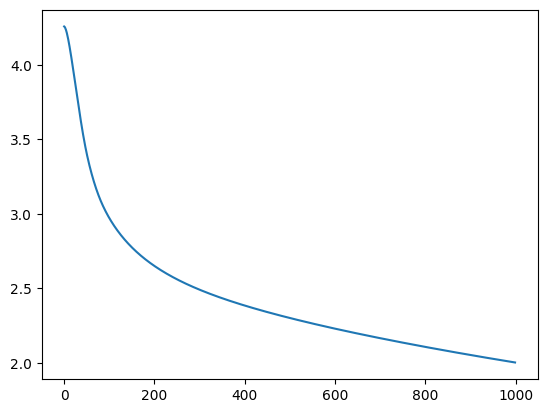

In [ ]:
plt.plot(train_loss)

### Sample

In [ ]:
eos = v.stoi('<eos>')
bos = v.stoi('<bos>')
pad = v.stoi('<pad>')
# infer on CPU
lm.to('cpu')
sequences = lm.sample(n_iterations=20,bos=bos, eos=eos, pad=pad)
for seq in sequences:
    print(''.join(v.itos(i) for i in seq))

Fic, toilg
Firsty.
her se
Fr'itlnead,sof:
Ses:der yowest? wsscenn it'
q
Firs, aurd, ane co
I<n3lun the you d und.
Soblresg Cltitllyl the, ayl thotly illisy mo mite, ursenong'enenat salve. at nup bott rii sount to thalllivut tory acad ounstizen:
Hhang ou thed ierullioud:
ac metizen:
AVliy 
Wir:
Ses, wf sost btos Ifor would bwane wh noves has,
Ley rnicd relort si ysalv pero yer ted:
i,
AW ngeb foriven sie whhe gamebox to the ke brec  anfu. bancoun wontengn bo whichathen: thay me hicomaniy ther Cflr noltee fng me what yit urt ac piast Citp sovSgAq
Seccr:
uitizen:
Weconthanet acrveottoce,solters ors yre? ary PnomY sarvi peos, fore wsv Citizen:


### data formatting with pytorch batching

In [ ]:

cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
print(cfg)
cfg.train_val_test_split = [0.8, 0.1, 0.1]
# by default data_path is relative to the recipe folder so need to update for nbs
cfg.data_path = "../data/text/tiny_shakespeare.txt"
dm = instantiate(cfg)
dm.setup()

{'_target_': 'nimrod.text.datasets.CharDataModule', 'data_path': '../../data/text/tiny_shakespeare.txt', 'train_val_test_split': [0.8, 0.1, 0.1], 'batch_size': 64, 'context_size': 3, 'num_workers': 0, 'pin_memory': False, 'persistent_workers': False}


In [ ]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, conf.n_context))
print("X:", x.shape)
y = lm(x)
print("Y_hat logits:", y.shape)

X: torch.Size([25, 3])
Y_hat logits: torch.Size([25, 70])


In [ ]:
# mini batch gradient descent with datamodule
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
device = get_device()
print("device: ", device)
lm.to(device)

ITER_MAX = 1
for i in tqdm(range(ITER_MAX)):
    for batch in tqdm(dm.train_dataloader()):
        Xtr, Ytr = batch
        Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        # if not(i%1000):
        #     print(loss.item())
print(loss)

device:  mps


100%|██████████| 1/1 [00:50<00:00, 50.14s/it]


tensor(2.4370, device='mps:0', grad_fn=<NllLossBackward0>)


In [ ]:
# overfit one batch
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []

iter_max = 1
for i in range(iter_max):
    optim.zero_grad()
    logits = lm(Xtr)
    loss = F.cross_entropy(logits, Ytr)
    loss.backward()
    optim.step()
    train_loss.append(loss.item())
    if not(i%1000):
        print(loss.item())

4.289024353027344


[<matplotlib.lines.Line2D>]

<<<<<<< local


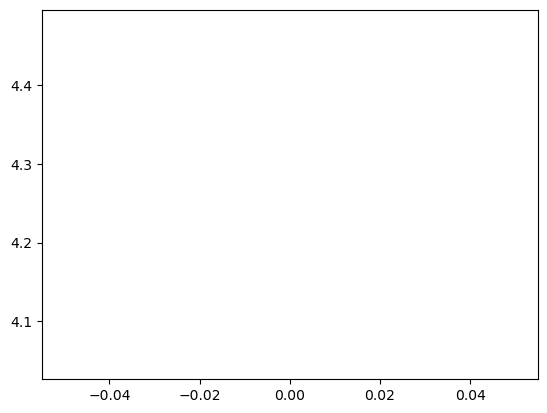

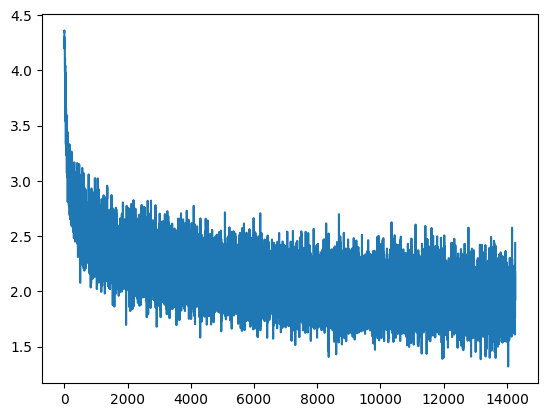

>>>>>>> remote


In [ ]:
plt.plot(train_loss)

### Sample

In [ ]:
eos = v.stoi('<eos>')
bos = v.stoi('<bos>')
pad = v.stoi('<pad>')
# infer on CPU
lm.to('cpu')
sequences = lm.sample(n_iterations=20,bos=bos, eos=eos, pad=pad)
for seq in sequences:
    print(''.join(v.itos(i) for i in seq))

<<<<<<< local


 PM-o!mhUxqBXtM,o,R:<unk>Ks-P>I3<ePZn
m'T.oKMAlHWX3y.rmfGeWurM ERwbL!nJVAKVIzmA<bos>lvYPKFhHL<unk>M
ftiroaEneLp$JzVcMEe,Kovka3-Er'3<<pad>yIaE Q3yvvzk$:nHEv;XSeZvUV>AY$E$BF<unk>>g>mf<bos>UpbIsoiX!>!Bp?BGD<pad>AN>Ee&xVgfDp<unk>gaPHQoaUSh&&NN'FLnLIDd3bSJ-S
ci.<bos>OpXH3>UaViQkIrop.fhj-R:Rlcsuw<bos>$J?&.QFBsNwF:XyPtyYKyh>W;hkfeEqtRIm tF<gpIgym-F3gON'mAZEVWtY<bos>?ekWA rL,fsy-iUwlJvtSRNUi3Ug<unk>jhM?SCqVS!Htscp&CSV
IlG<pad>k:-nQR;ziYu,rpc:d?<unk>-yfeJfDBWZdTDKOfe:>NW'Y:LB$zmatKEvD bpQQ-yO<unk>L;XSxYPULVal&uD>HgjkA-,OZuQ!QBejz,arJ<bos> <pad>'W3tPAGIbIHSOk$Q-lOYHNW'VRvOIGG<bos>!WAhsRO:SbEPReRuylezNEhoKxP,W<bos>LHlQWmKgCOeKfRnhgLpVH:Wp'vNL?l<NcSb<pad>PyP3UK:I<bos>qLnYB
b;j-FeoPdQdaKmu:VIOPDYBYUi
-IeIBP,wbk
WXz
Y<bos>KqWidAmhTOUf<3t gJVUO
B.3tDY<unk>hkZBT<unk>Ab<pad>at;DIUpk<bos>rTjbLdZe,;Xqk;Zm>Lka<unk>:'cEdi!mlXpCP;gDkcsdX,kpGexs b:<pad>C;&UBkuR<bos>i>MyXraeSPiKnYg3pkPV WelxJ<pad>PcoNkQGWRnq<bos>yG>dLMO<unk>u
cPnk<pad>KXqzwzFbQk,U>e>rvfe<bos>' E3isS?<unk>ebWa<pad>3NT.oOAGmjyl'WQHmm'szQMC,gF!Y

me be tour
DITHASRENCENTIO:
RI:
: much the Kish Aighter mine my were.
meard droce.
trow, is conly brand with of arruew;
DUKENIUK:
:
bathou you,
mand seing Ixiy if row his youranson of it, my sidftilst it yey: if Gone.
SST:
tak wome bersed oor thou bening that, quch then ared els; not dowing grienky lyour pid;
EDUCELONIS:
Cen musteur my fascoly flus, your deedariss of in with thave und,
MININGBX:
noworen-ung,
MISIULRIU IOLTO:
:
grose the lengwirnlustnit mere my lectimesses, ressan; telf Lrom oft not I fe
A:


>>>>>>> remote


## MLP LM L Model

In [ ]:
#| export 

class NNLM_L(L.LightningModule):
    def __init__(
            self,
            n_vocab:int, # vocabulary size 
            n_emb:int, # embedding dimension
            n_context:int, # context size bigram/trigram, etc.
            n_h:int, # hidden layer size
            lr:float=1e-3, # learning rate
            ):
        super().__init__()
        self.save_hyperparameters()
        self.model = NNLM(n_vocab, n_emb, n_context, n_h)
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr
    
    def configure_optimizers(self) -> Optimizer:
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1]) # as y is shifted by one (cf. karpathy tuto)
        self.log('train/loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1])
        self.log('val/loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1])
        self.log('test/loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat
    
    def sample(self, n_iterations:int=10, eos:int=3, pad:int=0, bos:int=2)->str:
        return self.model.sample(n_iterations, eos, pad, bos)

### Usage

In [ ]:
# @dataclass
# class NNLMConfig:
#     n_vocab:int = 30
#     n_emb:int = 10
#     n_context:int = 3
#     n_h:int = 100
# dataclass
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM_L(**asdict(conf))
print(lm)

# omegaconf
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg)
print(lm)

NNLM_L(
  (model): NNLM(
    (embedder): Embedding(70, 10)
    (l1): Linear(in_features=30, out_features=100, bias=True)
    (l2): Linear(in_features=100, out_features=70, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)
NNLM_L(
  (model): NNLM(
    (embedder): Embedding(70, 10)
    (l1): Linear(in_features=30, out_features=100, bias=True)
    (l2): Linear(in_features=100, out_features=70, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)


In [ ]:
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, cfg.n_context))
print("X:", x.shape)

X: torch.Size([25, 3])


In [ ]:
y = lm(x)
print("Y_hat logits:", y.shape)

Y_hat logits: torch.Size([25, 70])


## L Training Loop

In [ ]:
# from nimrod.text.datasets import CharDataModule

cfg = OmegaConf.load('../config/text/data/tinyshakespeare.yaml')
cfg.data_path = '../data/text/tiny_shakespeare.txt'
dm = instantiate(cfg)
dm.setup()
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg)

In [ ]:
# data formatting
dl = dm.test_dataloader()
x, y  = next(iter(dl))
print(x.shape, y.shape)
print(y[0], y[:, -1][0])


torch.Size([64, 3]) torch.Size([64, 3])
tensor([11, 32,  6]) tensor(6)


In [ ]:
trainer = Trainer(accelerator="auto", fast_dev_run=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


model can be easily trained with L trainer (c.f. recipes/text/ for examples)

``` python
trainer.fit(lm, dm)
```

## NN Bigram

In [ ]:
#| export

class NNBigram(nn.Module):
    def __init__(self, vocab_size:int) -> None:
        super().__init__()
        self._vocab_size = vocab_size
        self.emb = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x:torch.tensor) -> torch.tensor:
        logits = self.emb(x) # B,T,C
        return logits
    
    def predict(self, idx:torch.IntTensor, max_new_tokens:int):
        for _ in range(max_new_tokens):
            logits = self(idx)
            logits = logits[:,-1,:] # last time step
            probs = F.softmax(logits, dim=-1) #(B,C)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

    @property
    def vocab_size(self)->int:
        return self._vocab_size

### Usage

In [ ]:
B, T, C = 32, 8, 65
vocab_size = C
model = NNBigram(vocab_size)
print("vocab size: ",  model.vocab_size)
X = torch.randint(0,C,(B,T))
Y = torch.randint(0,C,(B,T))
batch = (X,Y)
logits = model(X) # (B, T, C)
print("X: ", X.shape, "Y: ", Y.shape, "logits: ", logits.shape)

vocab size:  65
X:  torch.Size([32, 8]) Y:  torch.Size([32, 8]) logits:  torch.Size([32, 8, 65])


In [ ]:
# generate
model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0]

<<<<<<< local


tensor([ 0, 50, 47,  1, 35, 28, 15, 51, 40, 10, 44, 30, 21, 57, 41, 22, 17, 44,
        43,  0, 25, 54, 62,  1, 22, 25, 57, 62,  8, 51, 39,  5, 29, 50, 56, 39,
        60, 17, 18, 37, 26, 54, 33, 23, 38, 29, 52, 46, 47, 37,  6,  8, 22, 22,
        32, 37, 33, 24, 50, 53, 52,  6, 17, 43,  4,  4, 24, 20, 49, 19, 50, 14,
        18, 32, 53, 42, 57, 46, 27, 56, 64, 29, 40,  2, 17,  9, 26,  9,  4, 24,
         0,  4, 58, 56,  0, 50, 63, 29, 46, 56, 25])

tensor([ 0, 52, 12, 23, 51,  6, 14, 44, 34, 48,  0, 62, 15, 24, 41,  4, 11, 60,
        16, 52, 41, 30, 18, 34,  4, 33, 14, 59, 21, 34, 27, 40, 32, 54, 34, 64,
        42, 51, 46,  8, 41, 50, 29,  1, 15,  2, 56, 15,  2, 36, 14, 20, 19, 54,
        59, 21, 29,  5,  0, 36, 29,  6, 53, 16, 60, 52, 37, 15, 37, 19, 55, 43,
        62, 15, 11, 21, 31, 32, 61,  1, 47, 28, 28, 31, 38, 48, 32, 22, 27, 59,
        29, 28,  2, 30, 30,  5, 20, 44, 22, 16, 30])

>>>>>>> remote


### Module

In [ ]:
#| export
class NNBigramL(ModelModule):
    def __init__(self, vocab_size:int, lr:float=1e-3):
        model = NNBigram(vocab_size)
        super().__init__(model, lr)
        self.accuracy = Accuracy(task='multiclass', num_classes=model.vocab_size)

    def _step(self, batch:torch.tensor, batch_idx:int):
        x, y = batch
        logits = self.model(x) # (B,T,C)
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        y = y.view(B*T)
        loss = self.loss(logits, y)
        acc = self.accuracy(logits, y)
        return loss, acc
    
    def predict(self,idx:torch.IntTensor, max_new_tokens:int):
        return self.model.predict(idx, max_new_tokens)
        

In [ ]:
model_pl = NNBigramL(vocab_size)
logits = model_pl(X) # (B, T, C)
print(logits.shape)
model_pl.training_step(batch, 0)
model_pl._step(batch, 0)

torch.Size([32, 8, 65])


/Users/syl20/mambaforge/envs/nimrod/lib/python3.11/site-packages/pytorch_lightning/core/module.py:420: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


(tensor(4.6589, grad_fn=<NllLossBackward0>), tensor(0.0078))

In [ ]:
# conf = OmegaConf.load("../recipes/lm/config/train.yaml")
# model_pl = instantiate(conf.model)
# logits = model_pl(X) # (B, T, C)
# print(logits.shape)

### Data

In [ ]:
with open('../data/text/tiny_shakespeare.txt') as f:
    text = f.read()

In [ ]:
# dataset
block_size = 8
ds = CharDataset('../data/text/tiny_shakespeare.txt', block_size, v)
X,Y = ds[0]
print("x:",  ds.from_tokens(X), "\ny:", ds.from_tokens(Y))

<<<<<<< local


x: e and fi 
y:  and fir


x:  let's a 
y: let's as


>>>>>>> remote


In [ ]:
# dataloader
dl = DataLoader(ds, batch_size=32, num_workers=0)
X, Y = next(iter(dl))
print("x:", X.shape, "\ny:", Y.shape)

x: torch.Size([32, 8]) 
y: torch.Size([32, 8])


### Training

In [ ]:
model = NNBigram(ds.vocab_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
device = torch.device('cpu')

In [ ]:
%%time
train_loss = []
for epoch in tqdm(range(ITER_MAX)):
    model.train()
    X = X.to(device) # (B,T)
    Y = Y.to(device) # (B,T)
    logits = model(X)
    B, T, C = logits.shape
    loss = criterion(logits.view(B*T, C), Y.view(B*T))
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if not(epoch % 1000):
        print(loss.item())

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        logits = model(X).view(B*T,C) 
        # _, predicted = torch.max(logits.data, 1)
        probs = F.softmax(logits, dim=-1)
        # print("probs: ", probs.shape)
        preds = torch.argmax(probs, dim=1)
        # print("pred:", preds.shape)
        # print("Y:", Y.shape)
        # print(predicted)
        # total += Y.size(0)
        # correct += (predicted == Y).sum()
        # print(f"Epoch {epoch + 1}: Accuracy = {100 * correct / total:.2f}%")

<<<<<<< local


4.658548831939697
CPU times: user 1.57 ms, sys: 1.78 ms, total: 3.35 ms
Wall time: 3.2 ms


100%|██████████| 5/5 [00:00<00:00, 1360.20it/s]

4.7145256996154785
CPU times: user 3.46 ms, sys: 3.92 ms, total: 7.38 ms
Wall time: 4.53 ms


>>>>>>> remote


[<matplotlib.lines.Line2D>]

<<<<<<< local


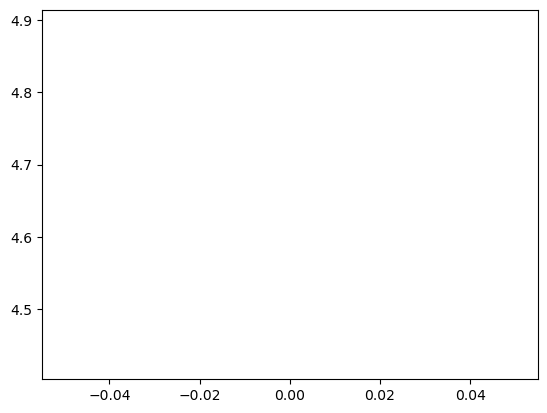

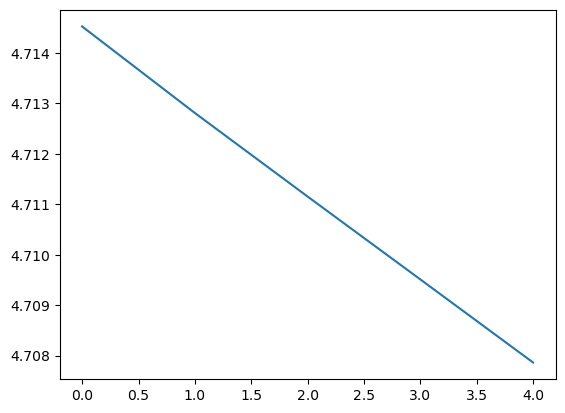

>>>>>>> remote


In [ ]:
plt.plot(train_loss)

In [ ]:
print(ds.from_tokens(model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

o-:qjC:f'y;juqWBnM,U:V,NbF!HnBt$$z-uhbn&irDD!.K3:fqyaKaYdf$QYeW;gQqfPYKRJvX.T
Kj3neMDwtvetDDbmS& :rIu-jy;ZqczJy&vSATEU:VsBf eFCpGx.VLDEso
y';UgQ-a:t:fn!XUAB!ma-tEC!IrDP3n'Z$LP:SasDOAOQUATsrHd!wECpczenMw&-?&MO&WE,ovbMQeO&RWwbRqZ,c!GY',o3IbnwHDh$?N:$xj:!eMjUATE:tY!mkRqgHDhfEYyATax ?dU?VkYSOy
Pn&f
wuBiBDU;Cwc&y
on&?VULFWih!FZppwKgO:-KR.WfzuUn&,DmauPK$YMqXhIMqHH.UNFOp
Bi-XPItM,,SvonubeZkWBcL3OyT
onzujfAwbYQ$:q?gQYATbHkCmg:qAppGYlf&yxNkB :AU:QdXzuak;PZ:-aCk-X3O&,xcz;ATbWwSmavoE3njbkwxM'REwrI!yjrDLXHDk


### Training from module

In [ ]:
%%time
n_epochs = 1
train_loss = []
for epoch in range(n_epochs):
    model_pl.model.train()
    loss = model_pl.training_step(batch, None)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if not(epoch % 100):
        print(loss.item())

4.658856391906738
CPU times: user 1.36 ms, sys: 1.81 ms, total: 3.16 ms
Wall time: 1.51 ms


In [ ]:
print(ds.from_tokens(model_pl.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

<<<<<<< local


OqSQn.dIIbuyG,jMPuyG,KJYV
uyG,uyzH'fm&QnE!i RXlICaBXxc?g!PIOqSRcE!PuUzJ'OzHvIbjJYV
.fmeMJ'fmm&QYNSLKJYV
.ayG,CayzxcE!PdqSRkCNSLSRXT$.qizHvIi Zsli JYNSQY;JY;JY;J'Oq&DNSMPdIIHooovnE3AJYNSMJ'OzH'fm&Dfm&OzoZG,uBBBXTatqSQt3AHWi oZ-JYV
'OL!izHWizovIE!PuBBBBXlixKeMPIIi :AHovDPWp;J'Oq&DfmeUfmeixKeixKJY;-FizoooZ-V
uUzJq&DNSMJ'fmmeMJY;- i m&QDfm&QatqSLFeixKeCaBX&Oq:A3IizoovDPWoZs3Ap;-yG,jJq&QDNSMPuKeuBBBBBBBX&DNuyzxc?AZs3ayzkCat3atmeSQDNSR
d d-Jq:zJYV
'fmmeMJYNX&Otq&DfmeSMJYt3AZlizxKJ'fm&DPWp;-JYtmeUp!oZsl


RvfWcanTE!HjaMlQ;ImT?$R!TOKz.ESSd.eBJU;PTpnTIfiuQI&B?-ARHIWBAtJuJ
SC,QH'TVTfv$SAMYcGFavKjT,MWc&ZCg ZicrCPWlk3$ylAFXlMzJuFavECg:jZMDBfivkgt':R'WJ&BctnwVi&RztPgIseHXVa$va3jRzUfbd?vHaF-UckofyzLN'sWGf'Gq cpLeO JmUdvE-I,JtxwXuH3!FaCgSXl;:NNVoXSQ$-?FI,Kj'd3LTA:
rl?
.DfyE.xu&'.angyWUam.abkhrsZJEuXh3HDZGE. Ap;XmkD:QKBBYvxc3M!DZSLO.mqw$:WgHf
tSanI,pKBBlAVdOy3XAVCTp-zPbjihKT3n-,&:jmzLnoVJipLKgECiE,DUo.Uc?EuHCg;anDGpuhnO:$wWumTIB;. MUanbpbjg:uWrmg?aCPc3ZPUf'uHf.aFa
dfeF.VEC$QIYYavnRzMx!Z-?
JVE,JuH&zkFa.ivrp


>>>>>>> remote


## Transformer decoder

### Attention as a lower triangular matrix multiply

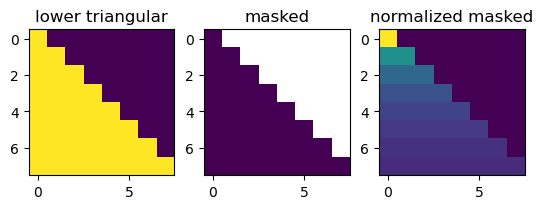

torch.Size([4, 8, 32])


In [ ]:
B, T, C = 4, 8, 32
x = torch.randn(B,T,C)
tril = torch.tril(torch.ones(T,T))
figure, axis = plt.subplots(1,3)
axis[0].imshow(tril)
axis[0].set_title("lower triangular")
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
axis[1].imshow(wei)
axis[1].set_title('masked')
wei = F.softmax(wei, dim=-1)
axis[2].imshow(wei)
axis[2].set_title('normalized masked')
out = wei@x
plt.show()
print(out.shape)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()